# Face Mask Detection with Transfer Learning

Aravind Kothandaraman
Unit 4 Incremental Capstone  
Class 2509 TA

**Note:** This notebook uses transfer learning with VGG16 to classify images as "with_mask" or "without_mask". Training can take 30+ minutes depending on your hardware. Consider working on other parts while the model trains.


## *Note to Matt*

*This was worked as a group during the breakout and we all contributed and sharing this version of code for this task-2.*

## Imports


In [10]:
# Install these if you are running locally or if your version runtime doesnt get this by default.
# for me, i had to do this in colab due to picking T4 GPU, not sure why!?, but switching to regular CPU didnt require this installation

# !pip install -q tensorflow pandas scikit-learn matplotlib

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report


## Load and Organize Image Data


In [13]:
source_dataset_zip = '/content/drive/MyDrive/AI_ML_course/01-Incremental_Capstone/Unit4-DeepLearning/0.3_Datasets/Face_mask_detection.zip'

# unzip the file
!unzip -q $source_dataset_zip

replace data/without_mask/without_mask_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [14]:
# Load file paths from both directories
with_mask_dir = "/content/data/with_mask"
without_mask_dir = "/content/data/without_mask"

# Get all .jpg files from each directory
with_mask_files = [os.path.join(with_mask_dir, f) for f in os.listdir(with_mask_dir) if f.endswith('.jpg')]
without_mask_files = [os.path.join(without_mask_dir, f) for f in os.listdir(without_mask_dir) if f.endswith('.jpg')]

# Create DataFrames with labels (1 = with_mask, 0 = without_mask)
with_mask_df = pd.DataFrame({'file_path': with_mask_files, 'label': 1})
without_mask_df = pd.DataFrame({'file_path': without_mask_files, 'label': 0})

# Combine into single DataFrame
all_data = pd.concat([with_mask_df, without_mask_df], ignore_index=True)

print(f"With mask images: {len(with_mask_df)}")
print(f"Without mask images: {len(without_mask_df)}")
print(f"Total images: {len(all_data)}")
print(f"\nClass distribution:")
print(all_data['label'].value_counts())

With mask images: 3725
Without mask images: 3828
Total images: 7553

Class distribution:
label
0    3828
1    3725
Name: count, dtype: int64


In [15]:
# Organize data for TensorFlow's image_dataset_from_directory
# This function requires subdirectories named after each class
base_dir = "facemask_data"
train_dir = os.path.join(base_dir, "training_set")
val_dir = os.path.join(base_dir, "test_set")

# Create subdirectories for each class
train_with_mask_dir = os.path.join(train_dir, "with_mask")
train_without_mask_dir = os.path.join(train_dir, "without_mask")
val_with_mask_dir = os.path.join(val_dir, "with_mask")
val_without_mask_dir = os.path.join(val_dir, "without_mask")

# Create directories if they don't exist
for dir_path in [train_with_mask_dir, train_without_mask_dir, val_with_mask_dir, val_without_mask_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Split data into train and validation sets (80/20 split)
# TODO: Use train_test_split with test_size=0.2, random_state=42, and stratify=all_data['label'].values
X_train, X_val, y_train, y_val = train_test_split(
    all_data['file_path'].values,
    all_data['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=all_data['label'].values
)

# Copy files to appropriate directories
print("Organizing training data...")
for file_path, label in zip(X_train, y_train):
    filename = os.path.basename(file_path)
    if label == 1:  # with_mask
        dest = os.path.join(train_with_mask_dir, filename)
    else:  # without_mask
        dest = os.path.join(train_without_mask_dir, filename)
    shutil.copy2(file_path, dest)

print("Organizing validation data...")
for file_path, label in zip(X_val, y_val):
    filename = os.path.basename(file_path)
    if label == 1:  # with_mask
        dest = os.path.join(val_with_mask_dir, filename)
    else:  # without_mask
        dest = os.path.join(val_without_mask_dir, filename)
    shutil.copy2(file_path, dest)

print("Data organization complete!")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")


Organizing training data...
Organizing validation data...
Data organization complete!
Training directory: facemask_data/training_set
Validation directory: facemask_data/test_set


## Load Dataset into TensorFlow


In [16]:
# Set image size (VGG16 expects 224x224 RGB images)
# Set IMG_SIZE to (224, 224)
IMG_SIZE = (224, 224)

# Load training images
# Parameters: train_dir, image_size=IMG_SIZE, batch_size=64
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=64
)

# Load validation images
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=64
)

# Save class names before applying cache/prefetch (they won't be accessible after)
class_names = train_ds_raw.class_names

# Optimize dataset performance
train_ds = train_ds_raw.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets loaded successfully!")
print(f"Class names: {class_names}")


Found 6042 files belonging to 2 classes.
Found 1511 files belonging to 2 classes.
Datasets loaded successfully!
Class names: ['with_mask', 'without_mask']


## Display Sample Images


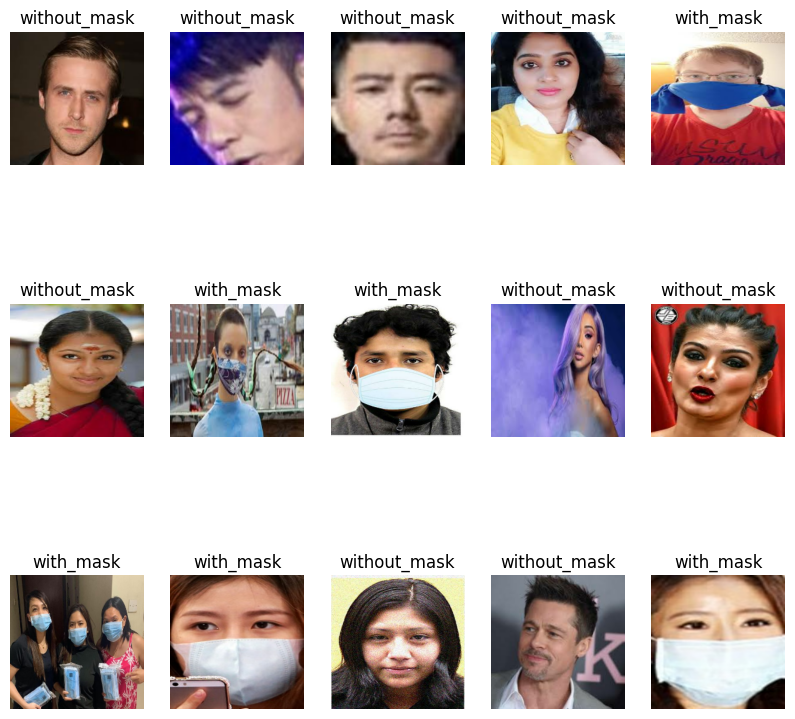

In [17]:
# Display sample images from training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # take one batch
    for i in range(15):  # show first 15 images
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


## Build Transfer Learning Model


In [18]:
# Load pre-trained VGG16 model (trained on ImageNet)
# Create VGG16 base model with:
# - weights='imagenet'
# - include_top=False
# - input_shape=(224, 224, 3)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model weights (we only train the new layers)
# Set base_model.trainable = False
base_model.trainable = False

# Build classifier on top of VGG16
# TODO: Create a Sequential model with:
# - base_model
# - GlobalAveragePooling2D layer
# - Dense layer with 64 units and 'relu' activation
# - Dense output layer with 2 units and 'softmax' activation
model = models.Sequential([
    base_model,  # Pre-trained feature extractor
    layers.GlobalAveragePooling2D(),  # Reduces spatial dimensions to 1D
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dense(2, activation='softmax')  # Output layer (2 classes)
])

# Compile model
# TODO: Compile with optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Train the Model


In [ ]:
# Train the model
# TODO: Use model.fit() with:
# - train_ds as training data
# - validation_data=val_ds
# - epochs=5
# Note: This may take 30+ minutes depending on your hardware
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


## Evaluate the Model


In [ ]:
# Get true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_probs = model.predict(val_ds, verbose=0)
y_pred = np.argmax(y_probs, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


## Questions to Consider

- How accurate was the model? Was it fast?
  > Model was slow, especially processing the EPOCHs.
  >
  > Accuracy was great!


- What could be done to improve the speed or accuracy of the model?
  >


Some of the improvements suggestions could be as below:

`Data augmentation`

how to experiment with it, is by below steps:
- Bring in data augmentation.
- Fine-tuning the learning rate.
- Unfreezing more layers of the VGG16 base model for fine-tuning.
- Using a smaller pre-trained model (e.g., MobileNetV2, EfficientNet) or quantization techniques.
- Increasing the number of training epochs. *to be really evaluated. Depends on dataset per my opinion*

## Trying Data Augmentation

Attempting some data augmentation techniques (like, random rotations, flips, zooms) to increase the diversity of the training dataset. This can help prevent overfitting and improve the model's generalization and accuracy without needing more physical images.


In [23]:
from tensorflow.keras import layers

# Create a Sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

print("Data augmentation layers created and applied to training dataset.")

Data augmentation layers created and applied to training dataset.


## Fine-tune Learning Rate

Experiment with different learning rates and using a learning rate scheduler. An optimal learning rate can lead to faster convergence and potentially higher accuracy by allowing the model to escape local minima more effectively.

In [24]:
from tensorflow.keras.optimizers import Adam

# Recompile the model with a specific learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with Adam optimizer and learning rate 0.0001.")

Model recompiled with Adam optimizer and learning rate 0.0001.


## Unfreeze More Layers (Fine-tuning)

Unfreeze some of the later convolutional layers in the VGG16 base model and fine-tune them along with the newly added classifier layers. This allows the model to learn more task-specific features from the pre-trained weights, which can boost accuracy.


In [25]:
import tensorflow as tf

# Unfreeze the base model completely
base_model.trainable = True

# Freeze the first 15 layers to keep low-level features fixed
for layer in base_model.layers[:15]:
    layer.trainable = False

# Recompile the model with a very low learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Base model layers partially unfrozen and model recompiled for fine-tuning.")
model.summary()

Base model layers partially unfrozen and model recompiled for fine-tuning.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 7,112,386 (27.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Use a Smaller Pre-trained Model or Quantization



#### Discussion on Smaller Pre-trained Models and Quantization

1.  **Advantages of Smaller Pre-trained Models (e.g., MobileNetV2, EfficientNet):**
    *   **Improved Speed:** Compared to VGG16, models like MobileNetV2 and EfficientNet have significantly fewer parameters and shallower network architectures. This leads to much faster training times and, critically, faster inference times. VGG16, with its 138 million parameters, is computationally expensive. Smaller models achieve similar performance with a fraction of the parameters, making them ideal for deployment on resource-constrained devices or applications requiring real-time predictions.
    *   **Architectural Differences:** These models employ techniques like depthwise separable convolutions (MobileNetV2) and compound scaling (EfficientNet) to achieve high accuracy with fewer computations. This contrasts with VGG16's sequential stack of convolutional layers, which are more resource-intensive.

2.  **Impact on Accuracy:** While switching to a smaller model *might* introduce a slight drop in accuracy due to the reduced model capacity and fewer parameters, this drop is often negligible for many practical tasks, especially when fine-tuned on a specific dataset. The goal is to find an optimal balance where the gains in speed and efficiency far outweigh a minimal loss in accuracy. For face mask detection, which is a relatively straightforward binary classification, the performance difference might be minimal.

3.  **Model Quantization:**
    *   **Description:** Model quantization is a technique used to further reduce the size of a neural network model and speed up inference. It involves converting the weights and activations of a model from a higher-precision floating-point format (e.g., 32-bit float) to a lower-precision integer format (e.g., 8-bit integer). This process can be applied during training (quantization-aware training) or post-training.
    *   **Benefits:** Quantization significantly reduces the model's memory footprint, which is crucial for edge devices. It also leads to faster execution because integer arithmetic is generally quicker and more energy-efficient than floating-point arithmetic.

4.  **Impact of Quantization on Accuracy and Deployment:**
    *   **Accuracy:** Post-training quantization can sometimes lead to a small drop in accuracy, but often it's very minimal, especially if the model is robust. Quantization-aware training can mitigate this by simulating the effects of quantization during training, helping the model learn to be more resilient to the precision reduction.
    *   **Deployment Efficiency:** The primary impact is on deployment. Quantized models require less storage, consume less power, and execute faster, making them highly suitable for mobile applications, embedded systems, and other environments where computational resources are limited.

5.  **Choosing a Smaller Model or Quantization for this Application:**
    *   **Current VGG16 Performance:** The VGG16 implementation, as observed, is slow during training, taking 30+ minutes for just 5 epochs. While it achieves high accuracy, its computational cost is substantial. If deployment to a mobile device or a real-time system is a goal, VGG16's speed becomes a critical bottleneck.
    *   **Trade-offs:**
        *   **Switching to a Smaller Model (e.g., MobileNetV2):** This would significantly reduce both training and inference times. Given that face mask detection is a well-defined task with clear features, a lighter model would likely achieve comparable high accuracy, potentially making it a better choice for efficiency without significant performance degradation.
        *   **Applying Quantization:** Quantization could be applied to the current VGG16 model (if deemed accurate enough) or, more effectively, to a smaller model. For example, if a MobileNetV2 model achieves 95% accuracy in 1/10th of the time of VGG16, and then quantization reduces its size by 4x and speeds up inference by 2x with only a 0.5% accuracy drop, the benefits are clear. For real-world applications where speed and resource usage are paramount, such as a live video mask detection system on a smart camera, both smaller models and quantization are crucial for practical deployment.